# Music

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21 # must import before fastai. otherwise stream.show() encounters elementtree error
from fastai.text import *

In [3]:
from fastai_data import MusicTokenizer
from encode_data import *
from midi_data import *
from gpt import gpt

In [4]:
# c = music21.corpus.parse(music21.corpus.chorales.Iterator(returnType='filename')[55]) c.show()

In [5]:
music21.environment.get('musicxmlPath')

PosixPath('/usr/bin/musescore')

In [6]:
path = Path('data/midi/v6/midi_transcribe/shortdur/')
get_files(path/'models/fastai/txl', recurse=True)

[PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/pop/2_ep7_rebuild.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/pop/2_ep7_rebuild_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/pop/1_ep20_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/clc/1_ep1_test_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/clc/1_ep20_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/clc/1_ep1_test.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/clc/1_ep20.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/hook/1_ep20_run1_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/hook/1_ep1_test_best.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/hook/1_ep20_run1.pth'),
 PosixPath('data/midi/v6/midi_transcribe/shortdur/models/fastai/txl/hoo

In [7]:
model_path = 'fastai/txl/hook/1_ep20_run1_best'

https://hpml2018.github.io/HPML2018_1.pdf

This paper suggests linear scaling rule does not work with RNNs. 3e-3 seems to be the magical number for 2k-8k

However, they didn't use schedule warmup, so I doubt they optimized the learning rate enough

In [8]:
bs=8
bptt=500

In [9]:
data = TextLMDataBunch.load(path, cache_name='tmp/hook', bs=bs, bptt=bptt)
data.valid_ds.x.processor[0] = TokenizeProcessor(tokenizer=MusicTokenizer())
t = data.train_ds[0][0]
t.text[:50], t.data

('xxbos || t1 nG3 t1 || t0 nF#3 t1 || t0 nA2 t1 || t',
 array([ 2,  9,  8, 17, ..., 43, 29, 57, 29]))

In [10]:
vocab = data.train_ds.vocab
vocab_size = len(vocab.itos); vocab_size

507

### Load Learner

In [11]:
cuda_enabled = torch.cuda.is_available()

In [158]:
tfmerXL_lm_config['ctx_len'] = 512
tfmerXL_lm_config['mem_len'] = 512

In [90]:
def predict_old(self, text:str, n_words:int=1, no_unk:bool=True, temperature:float=1., min_p:float=None):
    "Return the `n_words` that come after `text`."
    ds = self.data.single_dl.dataset
    for _ in progress_bar(range(n_words), leave=False):
        self.model.reset()
        xb, yb = self.data.one_item(text)
        res = self.pred_batch(batch=(xb,yb))[0][-1]
        if no_unk: res[self.data.vocab.stoi[UNK]] = 0.
        if min_p is not None: res[res < min_p] = 0.
        if temperature != 1.: res.pow_(1 / temperature)
        idx = torch.multinomial(res, 1).item()
        text += f' {self.data.vocab.itos[idx]}'
    return text

In [91]:
LanguageLearner.predict_old = predict_old

In [12]:
learn = language_model_learner(data, TransformerXL, clip=0.5)

/home/ubuntu/fastai/fastai/text/learner.py:212: UserWarning: There are no pretrained weights for that architecture yet!
  warn("There are no pretrained weights for that architecture yet!")


In [13]:
learn = learn.load(model_path)

## Done

In [ ]:
# learn.show_results(rows=5, max_len=25)

In [137]:
# idx = 3
# idx = 8
seed_len = 80
files = get_files(path/'hooktheory', recurse=True)
# file = files[idx]; file
file = np.random.choice(files); file

PosixPath('data/midi/v6/midi_transcribe/shortdur/hooktheory/pianoroll/t/the-legend-of-zelda/knights-academy/chorus_key.txt')

In [138]:
# best = Path('data/midi/midi_transcribe_v3_shortdur/hooktheory/pianoroll/e/elton-john/tiny-dancer/pre-chorus_key.txt')

In [139]:
with open(file, 'r') as f:
    txt_out = f.read()
notes = txt_out.split(' ')
seed = ' '.join(notes[:seed_len]); len(notes), seed


(336,
 '|| t0 nF2 t8 nA2 t8 nC3 t8 nC5 t4 || t3 nB4 t3 || t2 nA4 t1 || t0 nF2 t8 nA2 t8 nC3 t8 nF4 t8 || t7 nF2 t8 nA2 t8 nC3 t8 || t1 nA4 t2 || t1 nB4 t2 || t1 nC5 t2 || t1 nF2 t8 nA2 t8 nC3 t8 nD5 t2 || t1 nC5 t2 || t1 nB4 t2 || t1 nG4 t2 || t1 nF2 t8 nA2 t8 nC3 t8 nA4 t1')

In [140]:
ns = str2stream(seed)
ns.show('midi')

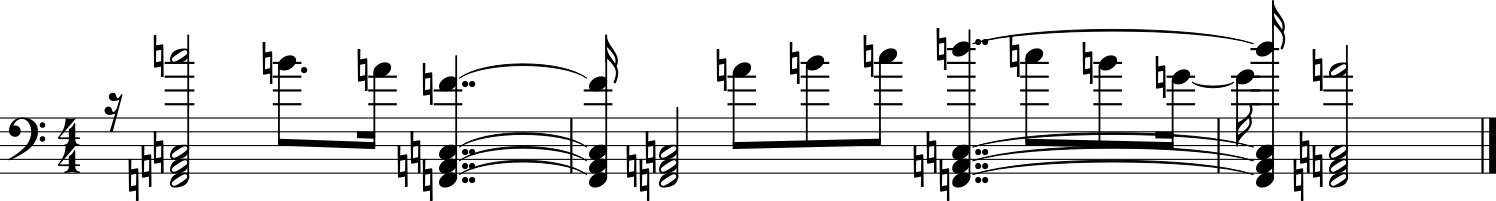

In [141]:
ns = str2stream(seed).show()

In [142]:
seed

'|| t0 nF2 t8 nA2 t8 nC3 t8 nC5 t4 || t3 nB4 t3 || t2 nA4 t1 || t0 nF2 t8 nA2 t8 nC3 t8 nF4 t8 || t7 nF2 t8 nA2 t8 nC3 t8 || t1 nA4 t2 || t1 nB4 t2 || t1 nC5 t2 || t1 nF2 t8 nA2 t8 nC3 t8 nD5 t2 || t1 nC5 t2 || t1 nB4 t2 || t1 nG4 t2 || t1 nF2 t8 nA2 t8 nC3 t8 nA4 t1'

In [143]:
# full song
str2stream(' '.join(notes)).show('midi')

### Predictions without beam search

In [144]:
# pred_out = learn.predict(seed, n_words=150, temperature=2); pred_out

In [151]:
pred_out = learn.predict_old(seed, n_words=150); pred_out

'|| t0 nF2 t8 nA2 t8 nC3 t8 nC5 t4 || t3 nB4 t3 || t2 nA4 t1 || t0 nF2 t8 nA2 t8 nC3 t8 nF4 t8 || t7 nF2 t8 nA2 t8 nC3 t8 || t1 nA4 t2 || t1 nB4 t2 || t1 nC5 t2 || t1 nF2 t8 nA2 t8 nC3 t8 nD5 t2 || t1 nC5 t2 || t1 nB4 t2 || t1 nG4 t2 || t1 nF2 t8 nA2 t8 nC3 t8 nA4 t1 || t0 nG4 t2 || t1 nE4 t1 || t0 nG4 t1 || t0 nG4 t1 || t0 nA4 t6 || t1 nE2 t8 nG2 t8 nC3 t8 || t3 nG4 t2 || t1 nE4 t2 || t1 nE2 t8 nG2 t8 nC3 t8 nG4 t2 || t1 nF4 t4 || t3 nE4 t1 || t0 nD4 t1 || t0 nF2 t8 nA2 t8 nC3 t8 nC4 t2 || t1 nA4 t2 || t1 nB4 t2 || t1 nC5 t2 || t1 nF2 t8 nA2 t8 nC3 t8 nD5 t2 || t1 nC5 t2 || t1 nB4 t2 || t1 nG4 t2 || t1 nF2 t16 nA2 t16 nC3 t16 nA4 t1 || t0 nG4 t2 || t1 nE4 t1 || t0 nG4 t1 || t0 nE4 t1 || t0 nG4 t6 || t5 nG4 t2 || t1 nF4 t2 || t1 nF2 t8 nA2 t8 nC3 t8 nE4 t2'

In [152]:
pred_only = pred_out.replace(seed, '').strip(); pred_only

'|| t0 nG4 t2 || t1 nE4 t1 || t0 nG4 t1 || t0 nG4 t1 || t0 nA4 t6 || t1 nE2 t8 nG2 t8 nC3 t8 || t3 nG4 t2 || t1 nE4 t2 || t1 nE2 t8 nG2 t8 nC3 t8 nG4 t2 || t1 nF4 t4 || t3 nE4 t1 || t0 nD4 t1 || t0 nF2 t8 nA2 t8 nC3 t8 nC4 t2 || t1 nA4 t2 || t1 nB4 t2 || t1 nC5 t2 || t1 nF2 t8 nA2 t8 nC3 t8 nD5 t2 || t1 nC5 t2 || t1 nB4 t2 || t1 nG4 t2 || t1 nF2 t16 nA2 t16 nC3 t16 nA4 t1 || t0 nG4 t2 || t1 nE4 t1 || t0 nG4 t1 || t0 nE4 t1 || t0 nG4 t6 || t5 nG4 t2 || t1 nF4 t2 || t1 nF2 t8 nA2 t8 nC3 t8 nE4 t2'

In [153]:
ns = str2stream(pred_only)
ns.show('midi')

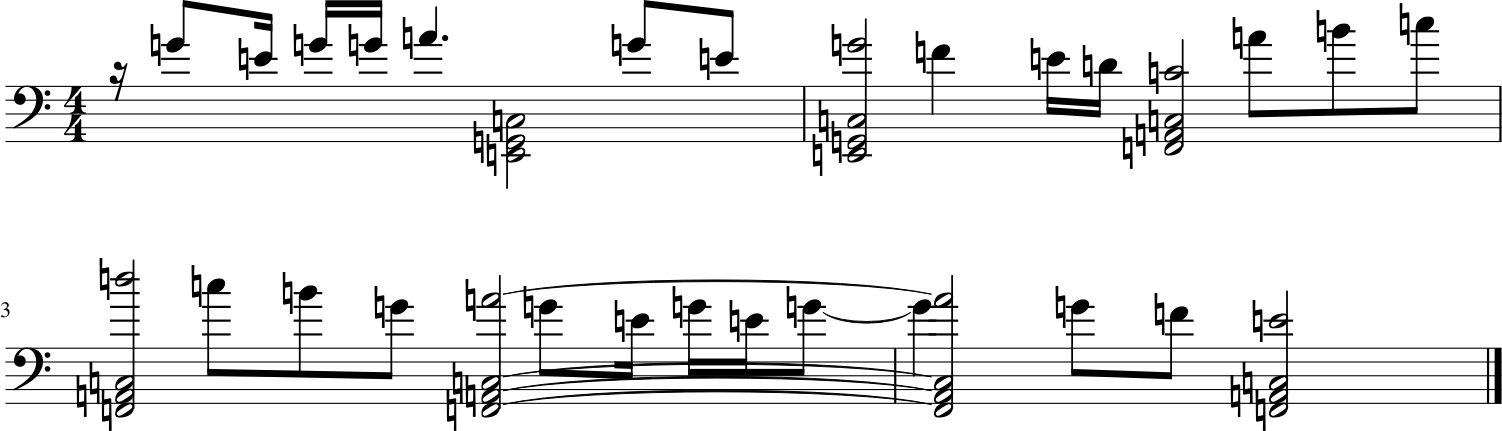

In [154]:
ns.show()

In [155]:
str2seq(pred_only)

[[],
 [G4t2],
 [],
 [E4t1],
 [G4t1],
 [G4t1],
 [A4t6],
 [],
 [E2t8, G2t8, C3t8],
 [],
 [],
 [],
 [G4t2],
 [],
 [E4t2],
 [],
 [E2t8, G2t8, C3t8, G4t2],
 [],
 [F4t4],
 [],
 [],
 [],
 [E4t1],
 [D4t1],
 [F2t8, A2t8, C3t8, C4t2],
 [],
 [A4t2],
 [],
 [B4t2],
 [],
 [C5t2],
 [],
 [F2t8, A2t8, C3t8, D5t2],
 [],
 [C5t2],
 [],
 [B4t2],
 [],
 [G4t2],
 [],
 [F2t16, A2t16, C3t16, A4t1],
 [G4t2],
 [],
 [E4t1],
 [G4t1],
 [E4t1],
 [G4t6],
 [],
 [],
 [],
 [],
 [],
 [G4t2],
 [],
 [F4t2],
 [],
 [F2t8, A2t8, C3t8, E4t2]]

In [156]:
ns = str2stream(pred_out)
ns.show('midi')

### Fastai beam search

In [117]:
[h.shape for h in learn.model[0].hidden]

[torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410]),
 torch.Size([1, 150, 410])]

In [118]:
pred_out = learn.beam_search(seed, n_words=200); pred_out

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 1. Got 10 and 1 in dimension 0 at /pytorch/aten/src/THC/generic/THCTensorMath.cu:83

In [40]:
xb,yb = learn.data.one_item(seed)

In [41]:
xb.shape

torch.Size([1, 80])

### Beam search

In [67]:
from beam_search import *

In [74]:
pred_beam, idxs = beam_search(seed, seq_length=200, beam_size=4, learn=learn, temperature=1)
pred_beam_only = pred_beam.replace(seed, '').strip(); pred_beam_only

'nB3 t16 nB4 t4 || t3 nE4 t10 || t9 nA4 t1 || t0 nB4 t1  nB3 t16 nB4 t4 || t3 nE4 t10 || t9 nA4 t1 || t0 nB4 t1  nB3 t16 nB4 t4 || t3 nE4 t10'

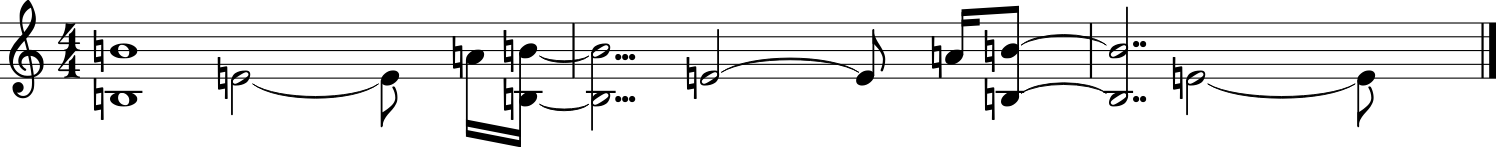

In [75]:
ns_only = str2stream(pred_beam_only).show()

In [76]:
ns_only = str2stream(pred_beam_only)
ns_only.show('midi')

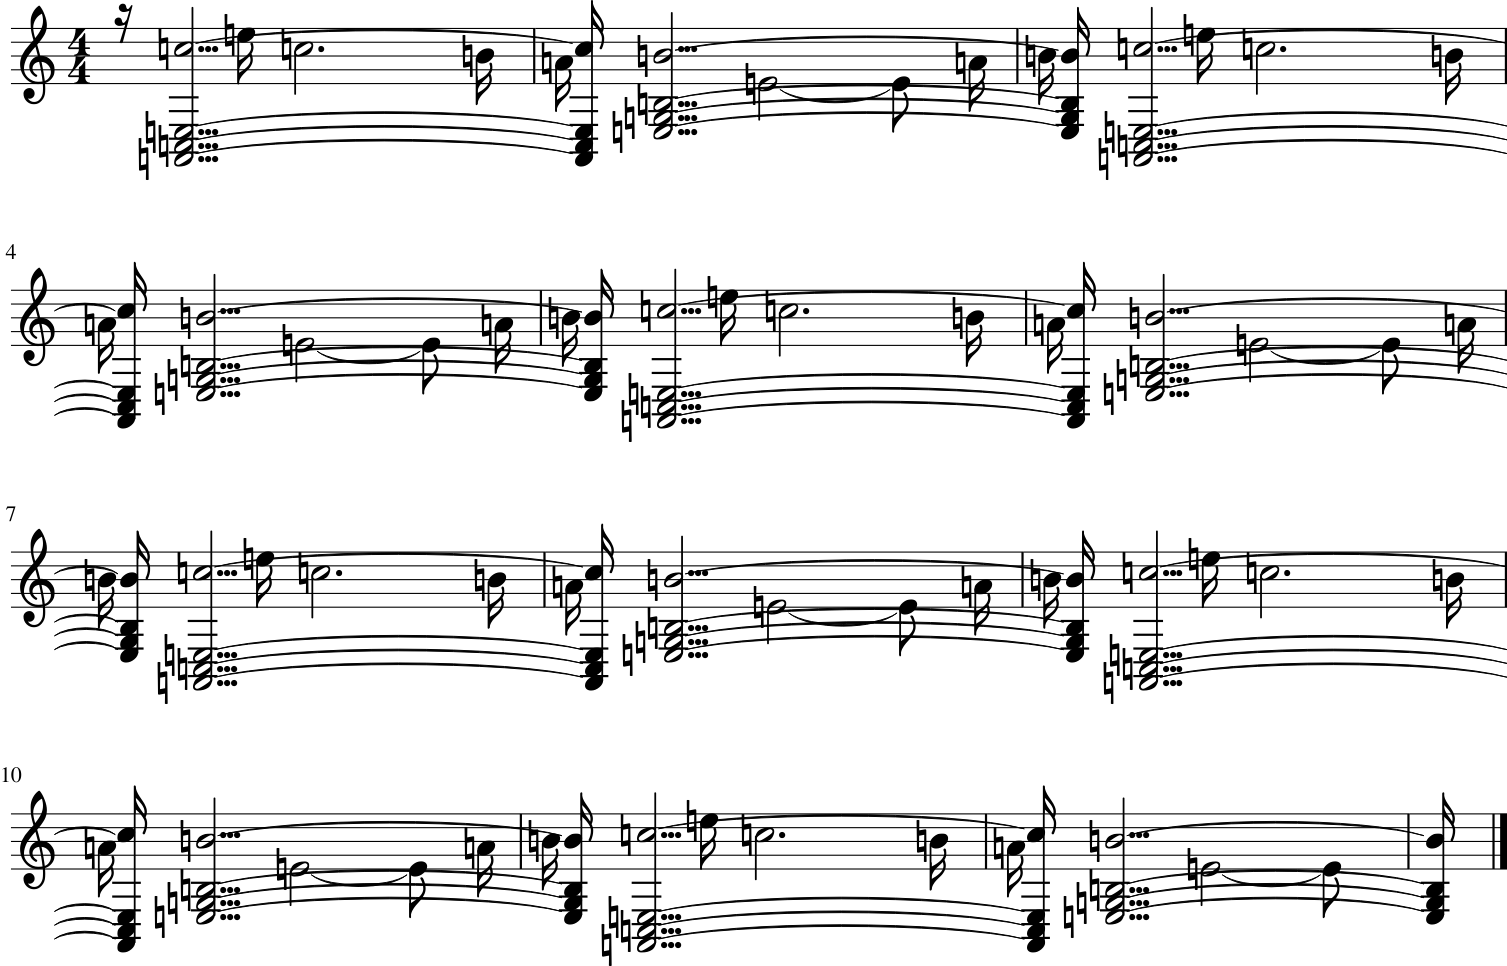

In [77]:
ns = str2stream(pred_beam).show()

In [72]:
ns = str2stream(pred_beam)
ns.show('midi')